In [10]:
import sys
sys.path.append(R'C:\Users\pjh7\git\k-wave-python')
import pyfus
from typing import List, Dict, Any, Tuple
import logging
import numpy as np
root = logging.getLogger()
loglevel = logging.INFO
root.setLevel(loglevel)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(loglevel)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

We'll start by generating a transducer and drawing it using some vtk-based methods

In [ ]:
arr = pyfus.Transducer.gen_matrix_array(nx=8, ny=8, pitch=4, kerf=.5, units="mm", impulse_response=1e5)
arr.draw()

Now we'll define the pulse and sequence parameters, the simulation setup, and generate a Protocol.

In [ ]:
pulse = pyfus.Pulse(frequency=400e3, duration=3/400e3)
sequence = pyfus.Sequence()
focal_pattern = pyfus.focal_patterns.Wheel(center=True, spoke_radius=5, num_spokes=5)
sim_setup = pyfus.SimSetup(dt=2e-7, t_end=100e-6)
protocol = pyfus.Protocol(
    pulse=pulse,
    sequence=sequence,
    focal_pattern=focal_pattern,
    sim_setup=sim_setup)

Now we can define a sonication target(s), set up the simulation, and compute the delays and apodizations needed to steer the sound to it.

In [ ]:
pt = pyfus.Point(position=(0,0,30), units="mm", radius=2)
pts = protocol.focal_pattern.get_targets(pt)
coords = protocol.sim_setup.get_coords()
params = protocol.seg_method.ref_params(coords)
delays, apod = protocol.beamform(arr=arr, target=pts[0], params=params)

Now we are ready to run the simulation.  Some custom edits to `k-wave-python` allow for caching of the gridweights, which only need to be computed once for a given grid size and source location.  This can speed up the simulation significantly, especially if a coarse grid that won't take the GPU too long to run is used.

In [11]:
ds = pyfus.sim.run_simulation(arr=arr, 
        params=params, 
        delays=delays,
        apod= apod,
        freq = pulse.frequency,
        cycles = np.max([np.round(pulse.duration * pulse.frequency), 20]),
        dt=protocol.sim_setup.dt,
        t_end=protocol.sim_setup.t_end,
        amplitude = 1,
        save_gridweights=False)

2024-04-12 22:23:00,785 - root - INFO - Calculating grid weights
2024-04-12 22:23:00,785 - root - INFO - Calculating grid weights
2024-04-12 22:23:01,455 - root - INFO - Getting binary mask
2024-04-12 22:23:01,455 - root - INFO - Getting binary mask
2024-04-12 22:23:01,853 - root - INFO - Getting distributed source signal
2024-04-12 22:23:01,853 - root - INFO - Getting distributed source signal
2024-04-12 22:23:02,243 - root - INFO - approximate size of source matrix: 2.33 G B ( float32 precision)
2024-04-12 22:23:02,243 - root - INFO - approximate size of source matrix: 2.33 G B ( float32 precision)
2024-04-12 22:23:02,283 - root - INFO - total computation time : 0.43 s
2024-04-12 22:23:02,283 - root - INFO - total computation time : 0.43 s
2024-04-12 22:23:02,284 - root - INFO - Running simulation
2024-04-12 22:23:02,284 - root - INFO - Running simulation
2024-04-12 22:23:02,286 - root - INFO - Starting Simulation Setup
2024-04-12 22:23:02,286 - root - INFO - Starting Simulation Setu

We can use all of `xarray`s built-in plotting capabilities to plot the data.

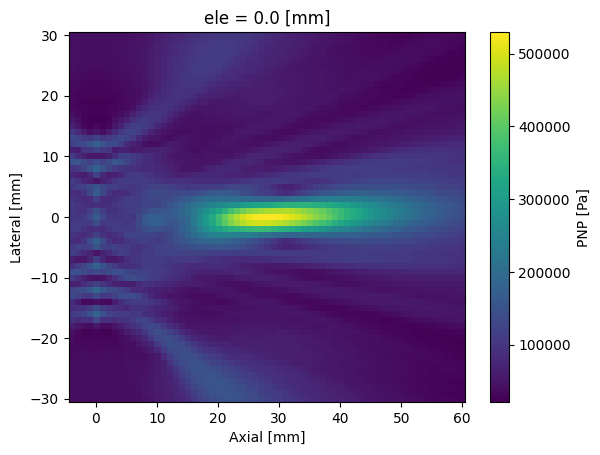

In [12]:
ds['p_min'].sel(ele=0).plot.imshow()

We can examine the output object, which is an `xarray.DataSet` object with 3 data variables: `p_max` (Peak Positive Pressure), `p_min` (Peak Negative Pressure), and `ita` (Time Averaged Intensity). It's attributes also contain the `source` pulse (an `xarray.DataArray`), and `output`, the raw K-Wave output structure.

In [13]:
ds

<xarray.Dataset>
Dimensions:  (lat: 61, ele: 61, ax: 65)
Coordinates:
  * lat      (lat) float64 -30.0 -29.0 -28.0 -27.0 -26.0 ... 27.0 28.0 29.0 30.0
  * ele      (ele) float64 -30.0 -29.0 -28.0 -27.0 -26.0 ... 27.0 28.0 29.0 30.0
  * ax       (ax) float64 -4.0 -3.0 -2.0 -1.0 0.0 ... 56.0 57.0 58.0 59.0 60.0
Data variables:
    p_max    (lat, ele, ax) float32 3.54e+04 3.568e+04 ... 4.517e+03 4.484e+03
    p_min    (lat, ele, ax) float32 3.65e+04 3.546e+04 ... 5.187e+03 4.874e+03
    ita      (lat, ele, ax) float64 0.0444 0.04192 ... 0.0008967 0.0007918
Attributes:
    source:   <xarray.DataArray 'source' (t: 251)>\narray([ 0.00000000e+00,  ...
    output:   {'Nt': array(500, dtype=uint64), 'Nx': array(81, dtype=uint64),...

Using `nibabel`, we can export the DataArray to a NIftI file. This requires a little bit of manipulation of the coordinates to extract the origin and affine matrix as NIftI needs them. This should get wrapped into a function in the future.

In [8]:
import nibabel as nb
p_min = ds['p_min'].data
coords = ds['p_min'].coords
affine = np.eye(3) * np.array([float(np.diff(coords[x][:2])) for x in coords])
origin = np.array([float(coords[x][0]) for x in coords]).reshape(3,1)
affine = np.concatenate([np.concatenate([affine, origin], axis=1),np.array([0,0,0,1]).reshape(1,4)], axis=0)
nb.Nifti1Image(p_min, affine).to_filename("p_min.nii.gz")

Finally, we can use some of the intermediate vtk methods to extract Actors from both the array and points objects, and pipe them to a since render:

In [14]:
import vtk
arr_actor = arr.get_actor(units="mm")
renderWindow = vtk.vtkRenderWindow()
renderer = vtk.vtkRenderer()
renderWindow.AddRenderer(renderer)
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
renderer.AddActor(arr_actor)
for pti in pts:
    pt_actor = pti.get_actor()
    renderer.AddActor(pt_actor)
renderWindow.Render()
renderWindowInteractor.Start()